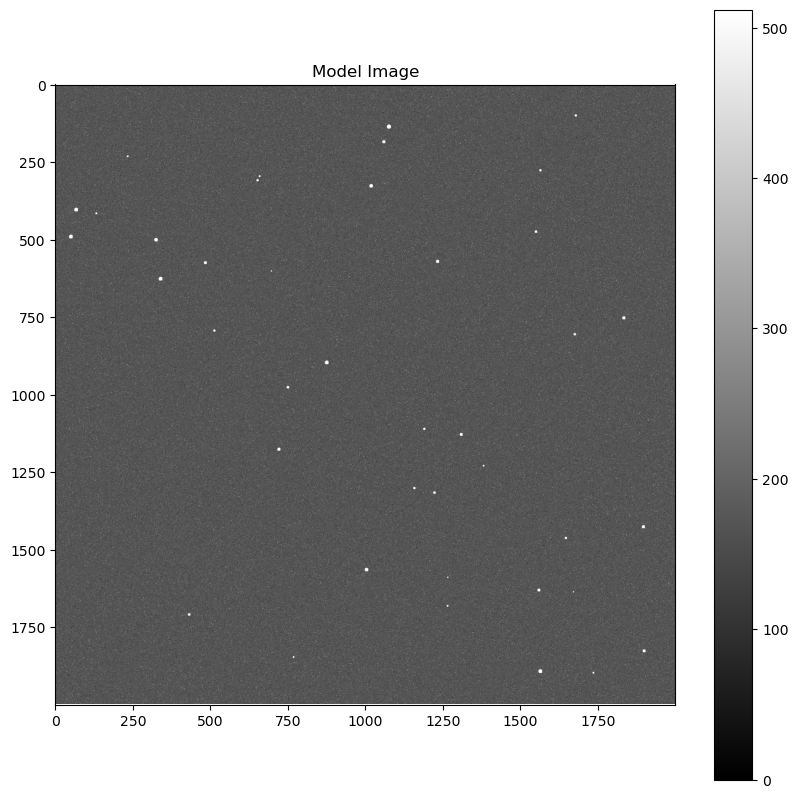

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, cauchy, laplace
from PIL import Image
#from perlin_noise import PerlinNoise  # Для генерации шума Перлина

# Размер изображения с телескопа
width, height = 2000, 2000


# Генерация шумов по Гауссу, Коши и Лаплассу
# Уровень нуля сдвинут на 100 пикселей
Gaus_noise = norm.rvs(loc=170, scale=30, size=(height, width)) # 20 = шум в ближнем ИК-диапазоне
Kosh_noise = cauchy.rvs(loc=170, scale=12, size=(height, width)) # 10 = тяжелые хвосты Коши не должны убивать Гаусса
Lapl_noise = laplace.rvs(loc=170, scale=20, size=(height, width)) # 15 = заметная ассиметрия без доминации над Гауссом

# Суперпозиция шумов
noise = (Gaus_noise + Kosh_noise + Lapl_noise)/3
#noise = np.clip(noise, 0, 512) # шум в заданном диапазоне




# Добавление "дефектных" пикселей
# Фиксированные пиксели с амплитудой [450, 512] в 0.001 поля зрения
defect_pixels = np.random.choice(width * height, int(0.001 * width * height), replace=False)
for idx in defect_pixels:
    x, y = idx // width, idx % width
    noise[x, y] = np.random.randint(450, 513)


    
    
    

# # Модельное изображение движущихся облаков. Шум Перлина
# # Параметры шума Перлина
# scale = 50.0
# octaves = 6
# persistence = 0.5  # 0.5 - баланс между крупными и мелкими деталями
# lacunarity = 2.0   # 2.0 - стандарт для создания естественных текстур

# Объект генератора шума
#noise_gen = PerlinNoise(octaves=octaves)

# Генерация шума
# Perl_noise = np.zeros((height,width))
# for i in range(height):
#     for j in range(width):
#         Perl_noise[i, j] = noise_gen([i / scale, j / scale])

# # Нормализация в диапазон [0, 1]
# min_val = np.min(Perl_noise)
# max_val = np.max(Perl_noise)
# if max_val != min_val:
#     Perl_noise = (Perl_noise - min_val) / (max_val - min_val)
# else:
#     Perl_noise = np.zeros_like(Perl_noise) # Если все значения одинаковы, обнуляем массив

# # Добавление шума Перлина к основному изображению
# noise += Perl_noise * scale  # Масштабируем влияние облаков
# noise = np.clip(noise, 0, 512)  # Ограничение значений






# Параметры оптической системы
Lambda = 1e-6  # Ближний ИК
f = 0.032  # Фокусное расстояние
D = 0.004  # Диаметр апертуры
pixel_size = 5e-6  # Размер пикселя

# Диаметр пятна Эйри в пикселях
# Пятно Эйри - дифракционный предел разрешения телескопа
airy = int(1.22 * Lambda * f / D / pixel_size)
### примерно 2 пикселя в изображении

# Функция для создания пятна Эйри
def create_airy(xc, yc, amplitude, diam):
    R = diam / 2
    x_min, x_max = max(0, int(xc - R)), min(width, int(xc + R))
    y_min, y_max = max(0, int(yc - R)), min(height, int(yc + R))
    x, y = np.meshgrid(np.arange(x_min, x_max), np.arange(y_min, y_max)) # сетка для всей картинки

    # Пятно Эйри не должно выходить за пределы массива.
    r = np.sqrt((x - xc) ** 2 + (y - yc) ** 2) # (xc, yc) - координаты центра пятна Эйри
    airy_spot = np.zeros_like(noise)
    airy_spot[y_min:y_max, x_min:x_max] = amplitude * (r <= R) # интенсивность сигнала
    return airy_spot


# Добавление сигналов
snr_values = [10, 5, 2]
num_signals_snr = [13, 13, 14] # количество сигналов для каждого SNR

true_centers = []  # Хранение истинных центров сигналов

for snr, num_signals in zip(snr_values, num_signals_snr):
    for _ in range(num_signals):
        # Генерация случайных координат центра сигнала на картинке с учетом границ
        xc_range = max(0, airy // 2), min(width, width - airy // 2)
        yc_range = max(0, airy // 2), min(height, height - airy // 2)
        xc, yc = np.random.randint(*xc_range), np.random.randint(*yc_range)

        true_centers.append((xc, yc))  # Сохраняем истинный центр

        # Амплитуда сигнала
        signal_amplitude = np.random.randint(300, 512)
        # # Уровень шума
        # noise_level = signal_amplitude / snr

        # Добавляем пятно Эйри
        airy_spot = create_airy(xc, yc, signal_amplitude, airy*random.randint(5, 15))

        # Добавляем сигнал
        noise = noise + airy_spot
        noise = np.clip(noise, 0, 512)




noise_uint8 = (noise / 512 * 255).astype(np.uint8)
plt.imsave("model_1.png", noise_uint8, cmap="gray")
np.savetxt("model_1.txt", noise.astype(int), fmt="%d")



# Визуализация и сохранение
plt.figure(figsize=(10, 10))
plt.imshow(noise, cmap="gray")
plt.title("Model Image")
plt.colorbar()

plt.savefig("model_image_1.png")
# plt.close()

In [11]:
noise[0][0]

512.0

In [16]:
import random

3